## 1. Import Libraries

In [6]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from ftfy import fix_text
from num2words import num2words

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import sklearn

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [19]:
# Load the data and check the first few lines
dataset_path = "../Raw Data Files/fake_job_postings.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Basic Understanding of the Data

In [20]:
print(dataset.shape)
dataset.info()

(17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

In [21]:
dataset.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<Axes: >

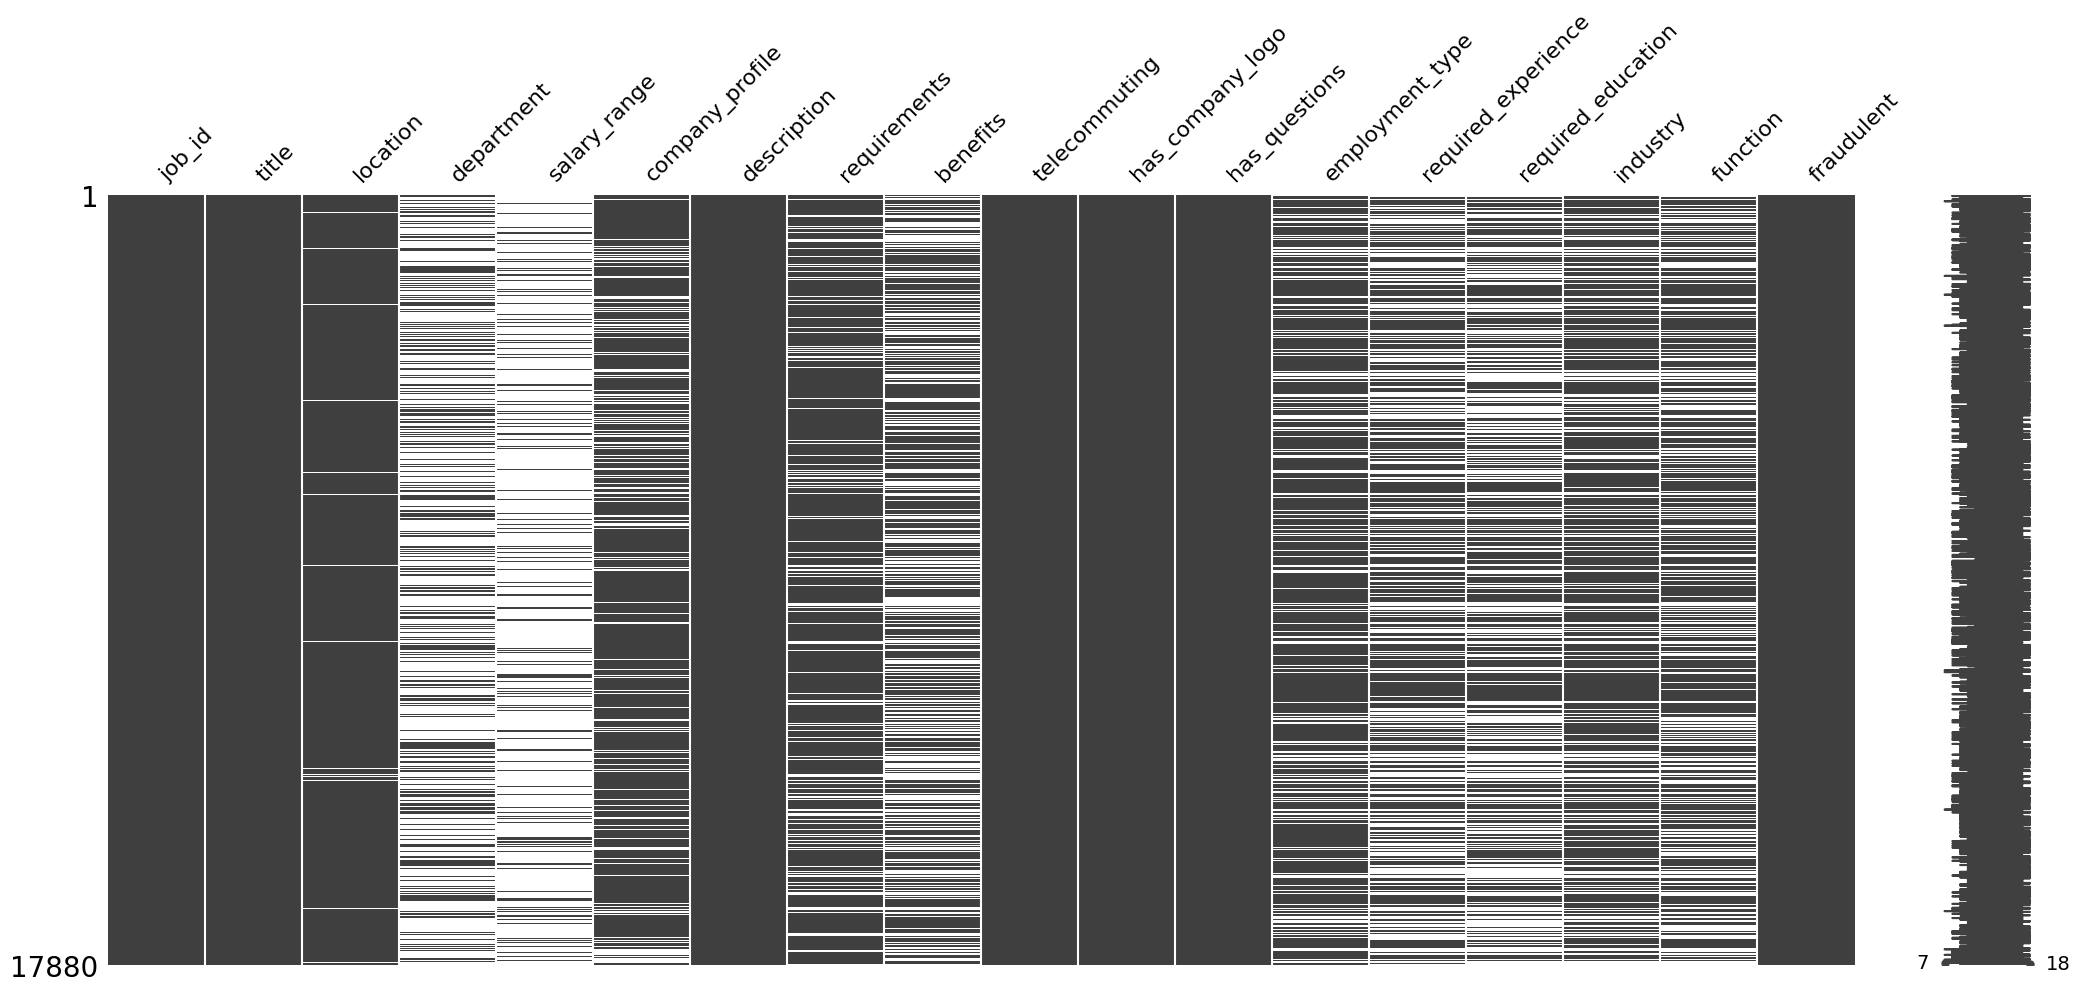

In [22]:
# Alternative way to have a quick glance to check missing values
missingno.matrix(dataset)

In [23]:
dataset.duplicated().sum()

0

From the data, we understand that there are 0 duplicated rows and there are a lot of data columns that has a lot of NA values especially department and salary range. This is followed by required_education, benefits and required_experience. We will dive deep to understand each data columns better to make a decision if we want to drop the column or not.

In [24]:
dataset.location.value_counts().head(10)

GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
US, TX, Houston          269
US, IL, Chicago          255
US, DC, Washington       251
DE, BE, Berlin           221
NZ, N, Auckland          218
Name: location, dtype: int64

In [25]:
dataset.company_profile.head(10)

0    We're Food52, and we've created a groundbreaki...
1    90 Seconds, the worlds Cloud Video Production ...
2    Valor Services provides Workforce Solutions th...
3    Our passion for improving quality of life thro...
4    SpotSource Solutions LLC is a Global Human Cap...
5                                                  NaN
6    Founded in 2009, the Fonpit AG rose with its i...
7    Airenvy’s mission is to provide lucrative yet ...
8    Solutions3 is a woman-owned small business who...
9    Novitex Enterprise Solutions, formerly Pitney ...
Name: company_profile, dtype: object

In [26]:
dataset.description.head(10)

0    Food52, a fast-growing, James Beard Award-winn...
1    Organised - Focused - Vibrant - Awesome!Do you...
2    Our client, located in Houston, is actively se...
3    THE COMPANY: ESRI – Environmental Systems Rese...
4    JOB TITLE: Itemization Review ManagerLOCATION:...
5    Job OverviewApex is an environmental consultin...
6    Your Responsibilities: Manage the English-spea...
7    Who is Airenvy?Hey there! We are seasoned entr...
8    Implementation/Configuration/Testing/Training ...
9    The Customer Service Associate will be based i...
Name: description, dtype: object

In [27]:
dataset.requirements.head(10)

0    Experience with content management systems a m...
1    What we expect from you:Your key responsibilit...
2    Implement pre-commissioning and commissioning ...
3    EDUCATION: Bachelor’s or Master’s in GIS, busi...
4    QUALIFICATIONS:RN license in the State of Texa...
5                                                  NaN
6    Your Know-How:                                ...
7    Experience with CRM software, live chat, and p...
8    MUST BE A US CITIZEN.An active TS/SCI clearanc...
9    Minimum Requirements:Minimum of 6 months custo...
Name: requirements, dtype: object

In [29]:
dataset.benefits.head(10)

0                                                  NaN
1    What you will get from usThrough being part of...
2                                                  NaN
3    Our culture is anything but corporate—we have ...
4                                Full Benefits Offered
5                                                  NaN
6    Your Benefits: Being part of a fast-growing co...
7    Competitive Pay. You'll be able to eat steak e...
8                                                  NaN
9                                                  NaN
Name: benefits, dtype: object

In [30]:
dataset.title.str.strip().value_counts().head(10)

English Teacher Abroad                                406
Customer Service Associate                            198
Graduates: English Teacher Abroad (Conversational)    144
Customer Service Associate - Part Time                 91
Software Engineer                                      90
English Teacher Abroad (Conversational)                83
Account Manager                                        81
Project Manager                                        71
Web Developer                                          69
Customer Service Representative                        63
Name: title, dtype: int64

In [31]:
dataset.industry.value_counts(dropna=False).head(10)

NaN                                    4903
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Financial Services                      779
Hospital & Health Care                  497
Consumer Services                       358
Telecommunications                      342
Name: industry, dtype: int64

In [32]:
dataset.department.value_counts(dropna=False).head(10)

NaN                       11547
Sales                       551
Engineering                 487
Marketing                   401
Operations                  270
IT                          225
Development                 146
Product                     112
Information Technology       86
Design                       76
Name: department, dtype: int64

In [33]:
dataset.function.value_counts(dropna=False).head(10)

NaN                       6455
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Name: function, dtype: int64

In [34]:
dataset.salary_range.value_counts(dropna=False).head(10)

NaN             15012
0-0               142
40000-50000        66
30000-40000        55
45000-67000        37
25000-30000        37
30000-50000        32
80000-100000       30
70000-90000        30
35000-45000        30
Name: salary_range, dtype: int64

In [35]:
dataset.telecommuting.value_counts()

0    17113
1      767
Name: telecommuting, dtype: int64

In [36]:
dataset.has_company_logo.value_counts()

1    14220
0     3660
Name: has_company_logo, dtype: int64

In [37]:
dataset.has_questions.value_counts()

0    9088
1    8792
Name: has_questions, dtype: int64

In [38]:
dataset.employment_type.value_counts(dropna=False)

Full-time    11620
NaN           3471
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

In [39]:
dataset.required_experience.value_counts(dropna=False)

NaN                 7050
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

In [40]:
dataset.required_education.value_counts(dropna=False)

NaN                                  8105
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

## 2. Feature Engineering

### 2.1 Salary Range > Salary Group

In [41]:
# salary_group: bin then fill in with most common
# salary_range: fill in with 'unspecified' and use frequency encoding

dataset['salary_group'] = dataset['salary_range']
for idx in (dataset['salary_group'].dropna()).index:
    Range = dataset.at[idx ,'salary_group'].split('-')
    try :
        starts = int(Range[0])
        if len(Range)==2:
          ends = int(Range[1])
        else:
          ends = starts
        salary = (starts + ends)/2
        if salary <= 1000:
          dataset.at[idx ,'salary_group'] = 'extremely low'
        elif salary > 1000 and salary <= 30000:
          dataset.at[idx ,'salary_group'] = 'low'
        elif salary > 30000 and salary <= 100000:
          dataset.at[idx ,'salary_group'] = 'slightly low'
        elif salary > 100000 and salary <= 500000:
          dataset.at[idx ,'salary_group'] = 'slightly high'
        elif salary > 500000 and salary <= 1000000:
          dataset.at[idx ,'salary_group'] = 'high'
        elif salary > 1000000:
          dataset.at[idx ,'salary_group'] = 'extremely high'
    except ValueError:
        dataset.at[idx ,'salary_group'] = np.NaN

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_group
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,NaN
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NaN
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,NaN
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,NaN
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,NaN


In [42]:
# salary_group
dataset.salary_group.value_counts(dropna=False).head(5)

NaN              15038
slightly low      1482
low                644
extremely low      346
slightly high      319
Name: salary_group, dtype: int64

### 2.2 Split Location

In [43]:
# split location
dataset['location_country'] = dataset['location'].str.split(',').str[0].str.strip()
dataset['location_county'] = dataset['location'].str.split(',').str[1].str.strip()
dataset['location_city'] = dataset['location'].str.split(',').str[2].str.strip()
columns = ['location_country','location_county','location_city']
dataset[columns] = dataset[columns].applymap(lambda x: x if x else np.NaN)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_group,location_country,location_county,location_city
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,NaN,US,NY,New York
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NaN,NZ,NaN,Auckland
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,NaN,US,IA,Wever
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,NaN,US,DC,Washington
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,NaN,US,FL,Fort Worth


In [44]:
# location_country
dataset['location_country'].value_counts(dropna=False).head(10)

US     10656
GB      2384
GR       940
CA       457
DE       383
NaN      346
NZ       333
IN       276
AU       214
PH       132
Name: location_country, dtype: int64

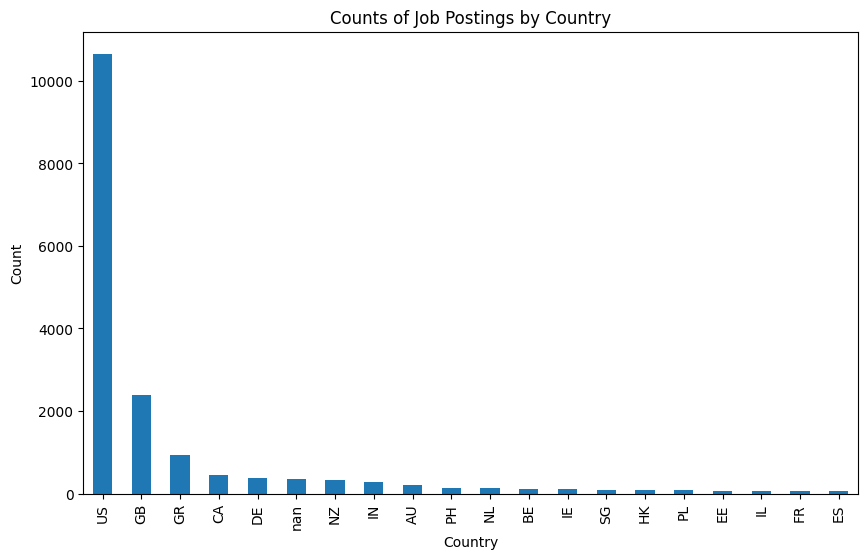

In [45]:
all_ctry = dataset['location_country'].value_counts(dropna=False)

top_20 = dataset['location_country'].value_counts(dropna=False).head(20)

plt.figure(figsize=(10, 6))
top_20.plot(kind='bar')
plt.title('Counts of Job Postings by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [46]:
# location_county
dataset['location_county'].value_counts(dropna=False).head(10)

NaN    2580
CA     2051
NY     1259
LND     992
TX      975
I       688
IL      424
FL      415
OH      372
VA      332
Name: location_county, dtype: int64

In [47]:
# location_city
dataset['location_city'].value_counts(dropna=False).head(10)

NaN              2068
London           1089
New York          685
Athens            548
San Francisco     486
Houston           272
Berlin            263
Washington        259
Chicago           259
Auckland          234
Name: location_city, dtype: int64

### 2.3 Company Profile, Description, Requirements, Benefits

In [48]:
dataset['have_company_profile'] = np.where(dataset['company_profile'].notnull(), 1, 0)
dataset['have_description'] = np.where(dataset['description'].notnull(), 1, 0)
dataset['have_requirements'] = np.where(dataset['requirements'].notnull(), 1, 0)
dataset['have_benefits'] = np.where(dataset['benefits'].notnull(), 1, 0)

# combine text
dataset[['company_profile']] = dataset[['company_profile']].fillna('')
dataset[['description']] = dataset[['description']].fillna('')
dataset[['requirements']] = dataset[['requirements']].fillna('')
dataset[['benefits']] = dataset[['benefits']].fillna('')
dataset['full_text'] = dataset['company_profile'] + ' ' + dataset['description'] + ' ' + dataset['requirements'] + ' ' + dataset['benefits']

dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_group,location_country,location_county,location_city,have_company_profile,have_description,have_requirements,have_benefits,full_text
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,NaN,US,NY,New York,1,1,1,0,"We're Food52, and we've created a groundbreaki..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NaN,NZ,NaN,Auckland,1,1,1,1,"90 Seconds, the worlds Cloud Video Production ..."
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,NaN,US,IA,Wever,1,1,1,0,Valor Services provides Workforce Solutions th...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,NaN,US,DC,Washington,1,1,1,1,Our passion for improving quality of life thro...
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,NaN,US,FL,Fort Worth,1,1,1,1,SpotSource Solutions LLC is a Global Human Cap...


## 3. Data Cleaning

In [49]:
# drop useless columns
drop_cols = ['job_id','location','company_profile','description','requirements','benefits']
dataset = dataset.drop(drop_cols,axis=1)
dataset.head()

,title,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_group,location_country,location_county,location_city,have_company_profile,have_description,have_requirements,have_benefits,full_text
0,Marketing Intern,Marketing,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,NaN,US,NY,New York,1,1,1,0,"We're Food52, and we've created a groundbreaki..."
1,Customer Service - Cloud Video Production,Success,NaN,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NaN,NZ,NaN,Auckland,1,1,1,1,"90 Seconds, the worlds Cloud Video Production ..."
2,Commissioning Machinery Assistant (CMA),NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,NaN,US,IA,Wever,1,1,1,0,Valor Services provides Workforce Solutions th...
3,Account Executive - Washington DC,Sales,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,NaN,US,DC,Washington,1,1,1,1,Our passion for improving quality of life thro...
4,Bill Review Manager,NaN,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,NaN,US,FL,Fort Worth,1,1,1,1,SpotSource Solutions LLC is a Global Human Cap...


### 3.1 Handle Missing Values

Columns with Missing Values:
- salary_range           15012
- location                 346
- company_profile         3308
description                1
requirements            2695
benefits                7210
- industry                4903
department             11547
function                6455
- employment_type         3471
required_experience     7050
required_education      8105

In [50]:
# dataset = dataset.dropna(subset=['description']) # drop when description is null, only 1 record
fill_cols = ['industry','department','function',
             'employment_type','required_experience','required_education',
             'location_country','location_county','location_city',
             'salary_range','salary_group']
dataset[fill_cols] = dataset[fill_cols].fillna('unspecified')
dataset.head()

,title,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_group,location_country,location_county,location_city,have_company_profile,have_description,have_requirements,have_benefits,full_text
0,Marketing Intern,Marketing,unspecified,0,1,0,Other,Internship,unspecified,unspecified,Marketing,0,unspecified,US,NY,New York,1,1,1,0,"We're Food52, and we've created a groundbreaki..."
1,Customer Service - Cloud Video Production,Success,unspecified,0,1,0,Full-time,Not Applicable,unspecified,Marketing and Advertising,Customer Service,0,unspecified,NZ,unspecified,Auckland,1,1,1,1,"90 Seconds, the worlds Cloud Video Production ..."
2,Commissioning Machinery Assistant (CMA),unspecified,unspecified,0,1,0,unspecified,unspecified,unspecified,unspecified,unspecified,0,unspecified,US,IA,Wever,1,1,1,0,Valor Services provides Workforce Solutions th...
3,Account Executive - Washington DC,Sales,unspecified,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,unspecified,US,DC,Washington,1,1,1,1,Our passion for improving quality of life thro...
4,Bill Review Manager,unspecified,unspecified,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,unspecified,US,FL,Fort Worth,1,1,1,1,SpotSource Solutions LLC is a Global Human Cap...


In [51]:
dataset.isna().sum()

title                   0
department              0
salary_range            0
telecommuting           0
has_company_logo        0
has_questions           0
employment_type         0
required_experience     0
required_education      0
industry                0
function                0
fraudulent              0
salary_group            0
location_country        0
location_county         0
location_city           0
have_company_profile    0
have_description        0
have_requirements       0
have_benefits           0
full_text               0
dtype: int64

### 3.2 Drop Columns with Low Variance

In [52]:
# Filter numeric columns only
numeric_columns = dataset.select_dtypes(include="number")

# Calculate the variance for numeric columns
variance_info = numeric_columns.var()

# Display the variance for each numeric column
print(variance_info)

telecommuting           0.041059
has_company_logo        0.162806
has_questions           0.249945
fraudulent              0.046091
have_company_profile    0.150790
have_description        0.000056
have_requirements       0.128016
have_benefits           0.240652
dtype: float64


In [53]:
del dataset['have_description']

### 3.3 Clean text data

In [54]:
def remove_stop_words(doc):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  docs = list(set(doc.split(' ')) - stop_words)
  return docs

def simple_stemmer(doc):
  stemmer= PorterStemmer()
  doc = ' '.join([stemmer.stem(word) for word in doc.split(' ')])
  return doc

# to clean data
def normalise_text(text,remove_stop_words=True):
    text = fix_text(text)
    text = text.lower() # lowercase
    text = text.replace("'","").replace("’","") # remove apostrophes ("can't">"cant")
    text = re.sub('#\S+#', " ", text) # removes #URL_...# #PHONE_...# #EMAIL_...# #*_...#
    text = re.sub('\xa0', " ", text) # remove \xa0
    text = re.sub('<.*?>'," ",text) # remove <> tags
    text = re.sub('#\S+', " ", text) # replaces hashtags
    text = re.sub('@\S+', " ", text)  # remove mentions
    text = re.sub("http\S+", " ", text) # remove URL addresses starting with http
    text = re.sub('www\S+', " ", text) # remove URL addresses starting with www
    text = re.sub('\d+', lambda x: ' '+num2words(x.group(), to='cardinal')+' ', text) # convert numbers to words ('food52'>'food fifty-two ')
    text = re.sub("[^a-zA-Z]", " ", text) # letters only
    text = re.sub('\s{2,}', " ", text).strip() # replace more than or equal to two white spaces into one white space
    if remove_stop_words:
      stop_words = set(nltk.corpus.stopwords.words('english'))
      text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    # if stem_words:
    # stemmer = PorterStemmer()
    # text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

In [55]:
text_cols = ['title', 'industry', 'department', 'function', 'employment_type', 'required_experience', 'required_education']
for col in text_cols:
    dataset[col] = dataset[col].apply(lambda x: normalise_text(x,remove_stop_words=False))
dataset.head()

,title,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_group,location_country,location_county,location_city,have_company_profile,have_requirements,have_benefits,full_text
0,marketing intern,marketing,unspecified,0,1,0,other,internship,unspecified,unspecified,marketing,0,unspecified,US,NY,New York,1,1,0,"We're Food52, and we've created a groundbreaki..."
1,customer service cloud video production,success,unspecified,0,1,0,full time,not applicable,unspecified,marketing and advertising,customer service,0,unspecified,NZ,unspecified,Auckland,1,1,1,"90 Seconds, the worlds Cloud Video Production ..."
2,commissioning machinery assistant cma,unspecified,unspecified,0,1,0,unspecified,unspecified,unspecified,unspecified,unspecified,0,unspecified,US,IA,Wever,1,1,0,Valor Services provides Workforce Solutions th...
3,account executive washington dc,sales,unspecified,0,1,0,full time,mid senior level,bachelors degree,computer software,sales,0,unspecified,US,DC,Washington,1,1,1,Our passion for improving quality of life thro...
4,bill review manager,unspecified,unspecified,0,1,1,full time,mid senior level,bachelors degree,hospital health care,health care provider,0,unspecified,US,FL,Fort Worth,1,1,1,SpotSource Solutions LLC is a Global Human Cap...


In [56]:
dataset['full_text'] = dataset['full_text'].apply(lambda x: normalise_text(x))
dataset['text_len'] = dataset['full_text'].apply(lambda x: len(x.split(' ')))
dataset.head()

,title,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_group,location_country,location_county,location_city,have_company_profile,have_requirements,have_benefits,full_text,text_len
0,marketing intern,marketing,unspecified,0,1,0,other,internship,unspecified,unspecified,marketing,0,unspecified,US,NY,New York,1,1,0,food fifty two weve created groundbreaking awa...,265
1,customer service cloud video production,success,unspecified,0,1,0,full time,not applicable,unspecified,marketing and advertising,customer service,0,unspecified,NZ,unspecified,Auckland,1,1,1,ninety seconds worlds cloud video production s...,562
2,commissioning machinery assistant cma,unspecified,unspecified,0,1,0,unspecified,unspecified,unspecified,unspecified,unspecified,0,unspecified,US,IA,Wever,1,1,0,valor services provides workforce solutions me...,231
3,account executive washington dc,sales,unspecified,0,1,0,full time,mid senior level,bachelors degree,computer software,sales,0,unspecified,US,DC,Washington,1,1,1,passion improving quality life geography heart...,493
4,bill review manager,unspecified,unspecified,0,1,1,full time,mid senior level,bachelors degree,hospital health care,health care provider,0,unspecified,US,FL,Fort Worth,1,1,1,spotsource solutions llc global human capital ...,367


### 3.4 Location Values

In [57]:
loc_cols = ['location_country','location_county','location_city']
for col in loc_cols:
    dataset[col] = dataset[col].apply(lambda x: normalise_text(x,remove_stop_words=False))

## 4. Exploratory Data Analysis

- wordcut: title,department,salary_range,industry,function,company_profile,description,requirements,benefits,location

In [58]:
dataset.describe()

,telecommuting,has_company_logo,has_questions,fraudulent,have_company_profile,have_requirements,have_benefits,text_len
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434,0.814989,0.849273,0.596756,249.818792
std,0.202631,0.403492,0.499945,0.214688,0.388317,0.357793,0.490563,139.391731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,145.000000
50%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,236.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,327.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1512.000000


### Relationship between Features and Classification Target

In [59]:
# title
dataset[dataset['fraudulent']==1]['title'].value_counts().head(10)

data entry admin clerical positions work from home                                 21
home based payroll typist data entry clerks positions available                    21
administrative assistant                                                           21
cruise staff wanted urgent                                                         21
customer service representative                                                    19
home based payroll data entry clerk position earn one hundred two hundred daily    12
payroll clerk                                                                      11
data entry                                                                         11
account sales managers eighty one hundred and thirty zero yr                       10
payroll data coordinator positions earn one hundred two hundred daily              10
Name: title, dtype: int64

In [60]:
dataset[dataset['fraudulent']==0]['title'].value_counts().head(5)

english teacher abroad                             406
customer service associate                         198
graduates english teacher abroad conversational    144
customer service associate part time                97
software engineer                                   92
Name: title, dtype: int64

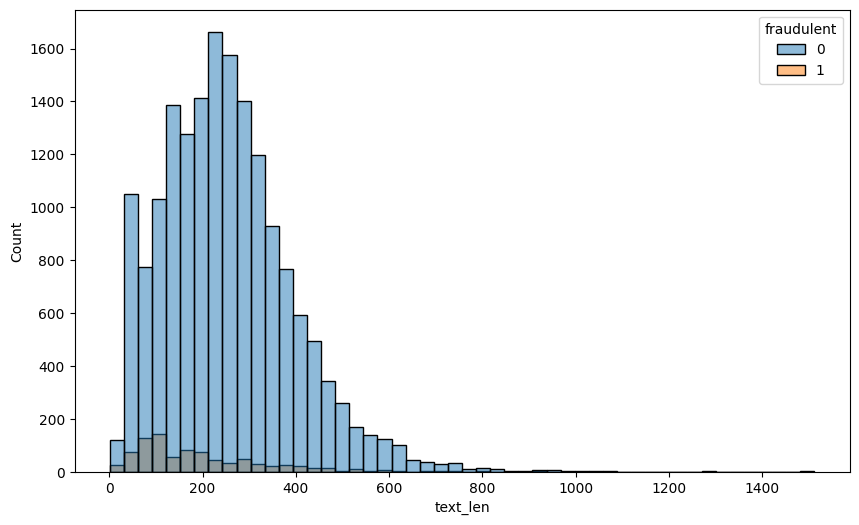

In [61]:
# text_len
plt.figure(figsize=(10,6))
sns.histplot(data=dataset, x="text_len", hue="fraudulent", kde=False, bins=50)
plt.show()

In [62]:
dataset['text_len'].describe()

count    17880.000000
mean       249.818792
std        139.391731
min          1.000000
25%        145.000000
50%        236.000000
75%        327.000000
max       1512.000000
Name: text_len, dtype: float64

In [63]:
dataset[dataset['fraudulent']==0]['text_len'].describe()

count    17014.000000
mean       252.674327
std        138.658736
min          5.000000
25%        149.000000
50%        239.000000
75%        329.000000
max       1512.000000
Name: text_len, dtype: float64

In [64]:
dataset[dataset['fraudulent']==1]['text_len'].describe()

count    866.000000
mean     193.717090
std      141.949505
min        1.000000
25%       89.000000
50%      158.500000
75%      265.750000
max      912.000000
Name: text_len, dtype: float64

In [65]:
# full_text
fraud_text = dataset[dataset.fraudulent == 1].full_text
nonfraud_text = dataset[dataset.fraudulent == 0].full_text

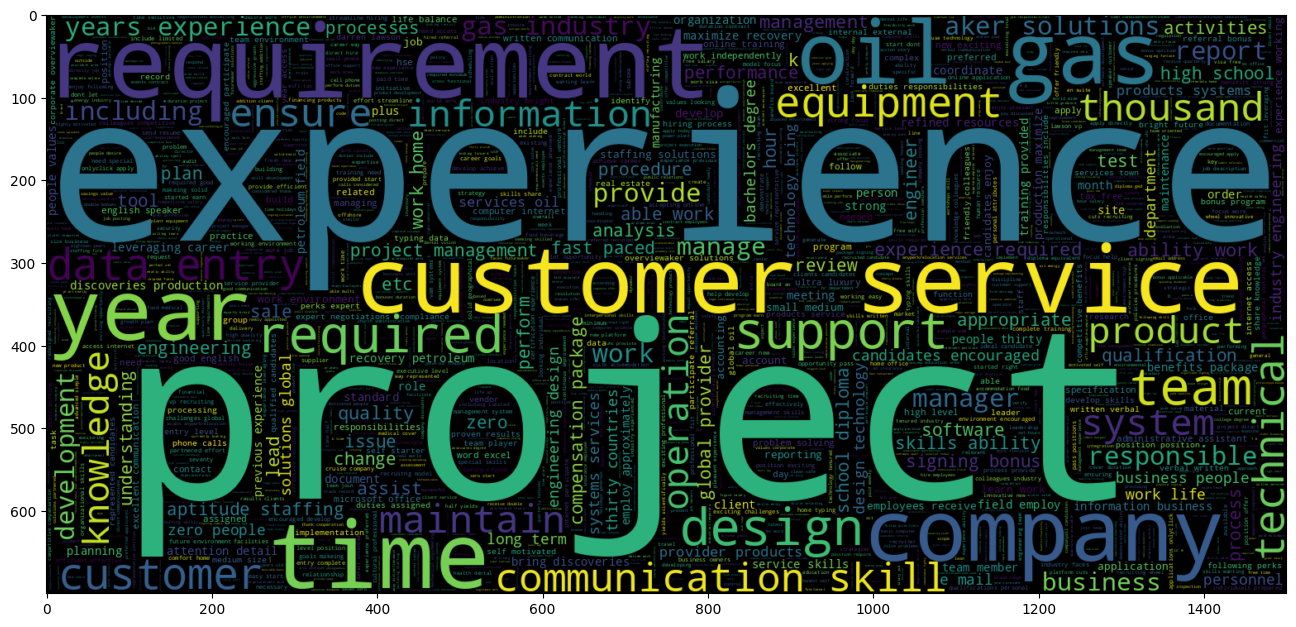

In [66]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(fraud_text)))
plt.imshow(wc,interpolation = 'bilinear')

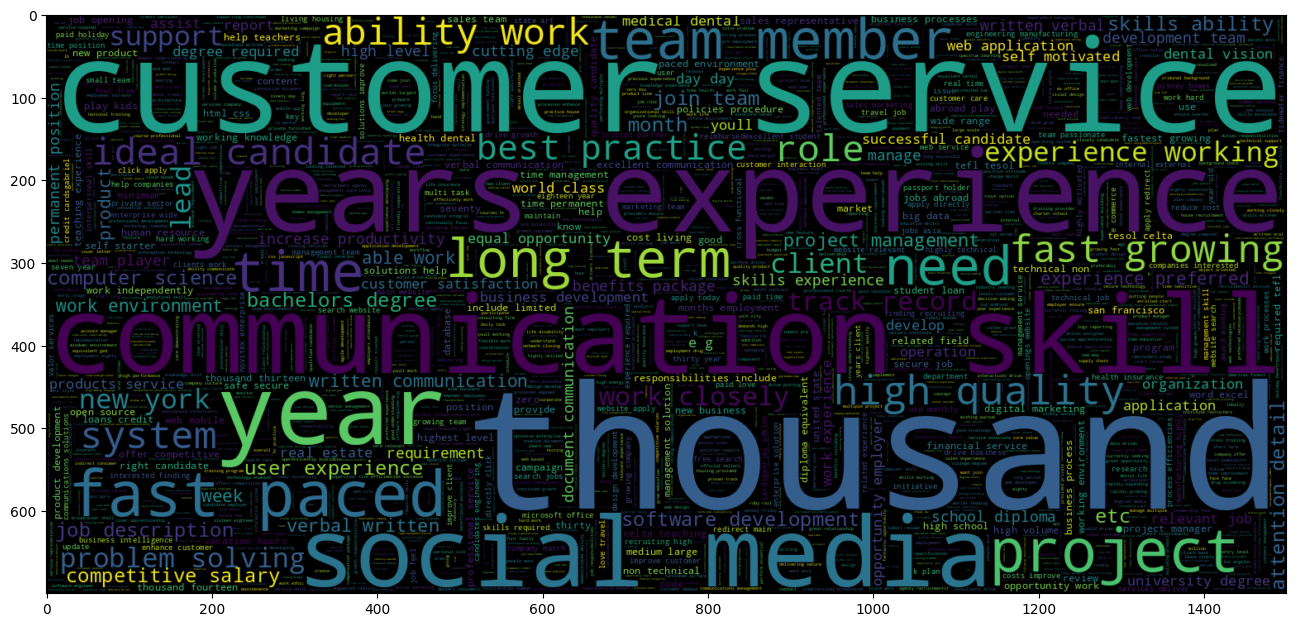

In [67]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(nonfraud_text)))
plt.imshow(wc,interpolation = 'bilinear')

<Axes: xlabel='have_company_profile'>

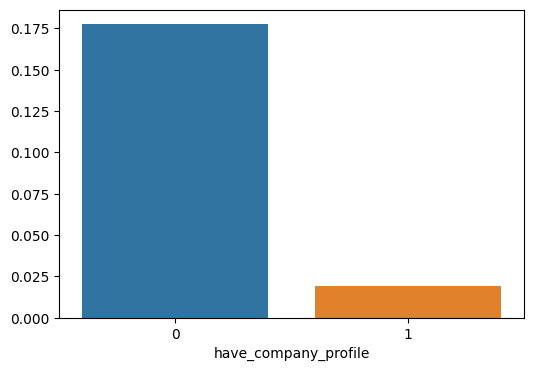

In [68]:
# have_company_profile
data = dataset.groupby('have_company_profile')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=data.index, y=data.values, ax=ax)

<Axes: xlabel='have_requirements'>

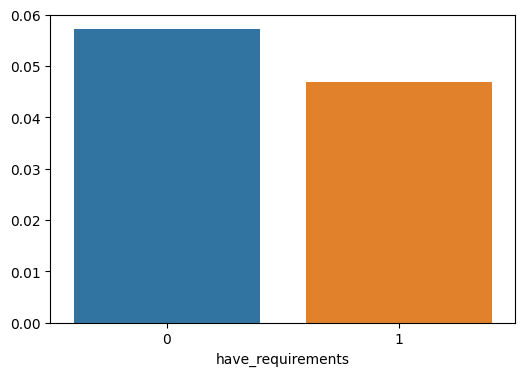

In [69]:
# have_requirements
data = dataset.groupby('have_requirements')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=data.index, y=data.values, ax=ax)

<Axes: xlabel='have_benefits'>

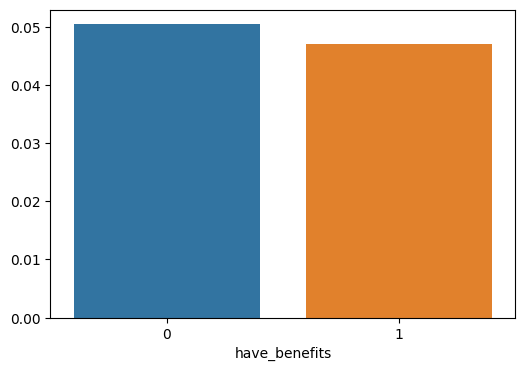

In [70]:
# have_benefits
data = dataset.groupby('have_benefits')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=data.index, y=data.values, ax=ax)

In [71]:
# salary_range
dataset[dataset['fraudulent']==1]['salary_range'].value_counts().head(5)

unspecified      643
7200-1380000      10
30000-50000        8
250000-500000      7
28000-32000        6
Name: salary_range, dtype: int64

In [72]:
dataset[dataset['fraudulent']==0]['salary_range'].value_counts().head(5)

unspecified    14369
0-0              138
40000-50000       65
30000-40000       51
45000-67000       37
Name: salary_range, dtype: int64

In [73]:
# salary_group
dataset.groupby('salary_group')['fraudulent'].mean()

salary_group
extremely high    0.052632
extremely low     0.078035
high              0.312500
low               0.090062
slightly high     0.053292
slightly low      0.073549
unspecified       0.042825
Name: fraudulent, dtype: float64

In [74]:
dataset[dataset['fraudulent']==1]['salary_group'].value_counts()

unspecified       644
slightly low      109
low                58
extremely low      27
slightly high      17
high               10
extremely high      1
Name: salary_group, dtype: int64

In [75]:
dataset[dataset['fraudulent']==0]['salary_group'].value_counts()

unspecified       14394
slightly low       1373
low                 586
extremely low       319
slightly high       302
high                 22
extremely high       18
Name: salary_group, dtype: int64

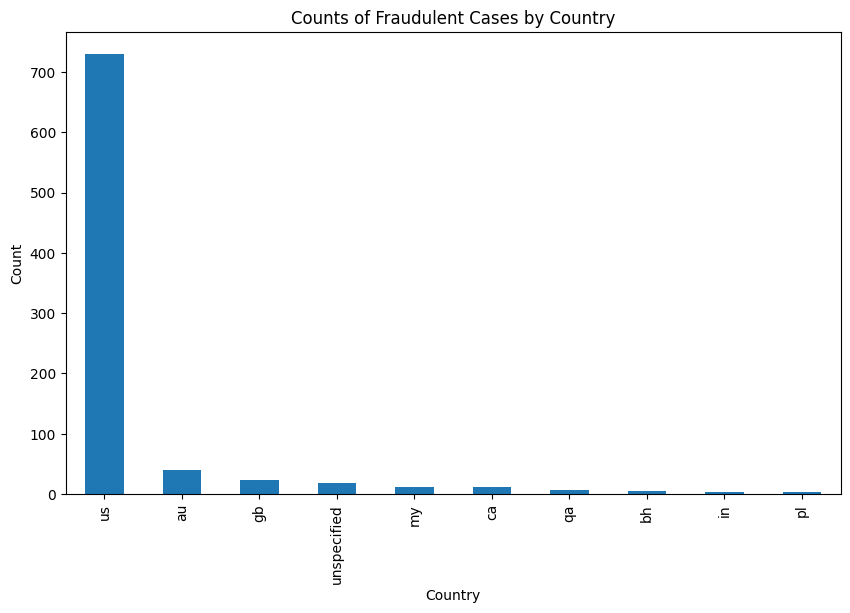

In [76]:
# location
fraudulent_ctry = dataset[dataset['fraudulent'] == 1]['location_country'].value_counts()
fraudulent_ctry_10 = fraudulent_ctry.head(10)
plt.figure(figsize=(10, 6))
fraudulent_ctry_10.plot(kind='bar')
plt.title('Counts of Fraudulent Cases by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

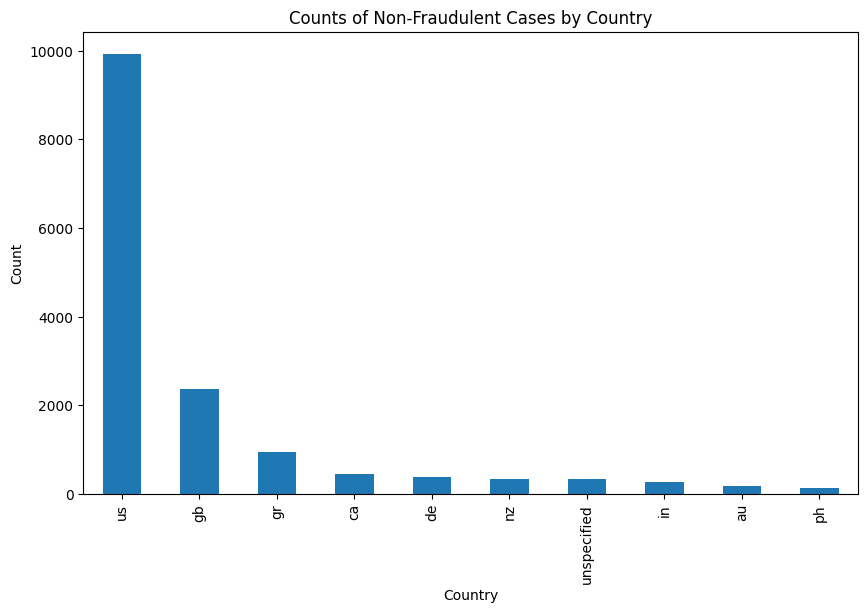

In [77]:
non_fraudulent_ctry = dataset[dataset['fraudulent'] == 0]['location_country'].value_counts()
non_fraudulent_ctry_10 = non_fraudulent_ctry.head(10)
plt.figure(figsize=(10, 6))
non_fraudulent_ctry_10.plot(kind='bar')
plt.title('Counts of Non-Fraudulent Cases by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [78]:
dataset[dataset['fraudulent']==1]['location_county'].value_counts().head(5)

tx             152
ca             143
unspecified     84
ny              68
md              35
Name: location_county, dtype: int64

In [79]:
dataset[dataset['fraudulent']==0]['location_county'].value_counts().head(5)

unspecified    2496
ca             1908
ny             1191
lnd             986
tx              823
Name: location_county, dtype: int64

In [80]:
dataset[dataset['fraudulent']==1]['location_city'].value_counts().head(5)

unspecified    156
houston         94
sydney          31
bakersfield     30
los angeles     30
Name: location_city, dtype: int64

In [81]:
dataset[dataset['fraudulent']==0]['location_city'].value_counts().head(5)

unspecified      1912
london           1102
new york          681
athens            560
san francisco     483
Name: location_city, dtype: int64

<Axes: xlabel='telecommuting'>

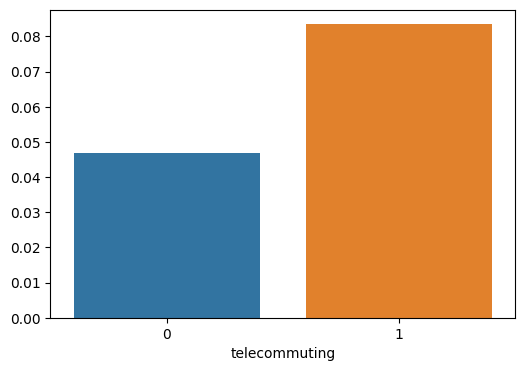

In [82]:
# telecommuting
telecommuting_fraud = dataset.groupby('telecommuting')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=telecommuting_fraud.index, y=telecommuting_fraud.values, ax=ax)

<Axes: xlabel='telecommuting', ylabel='count'>

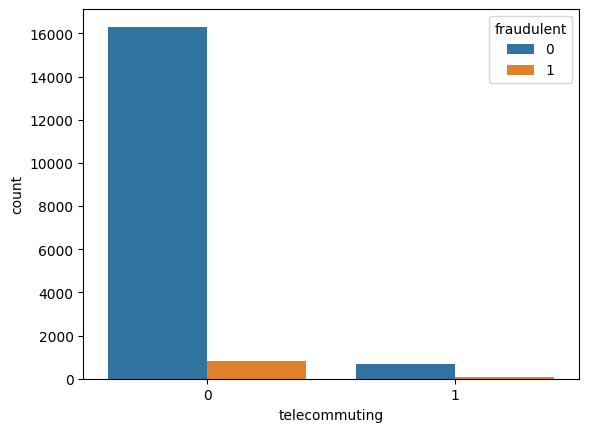

In [83]:
sns.countplot(x='telecommuting',data=dataset,hue='fraudulent')

<Axes: xlabel='has_company_logo'>

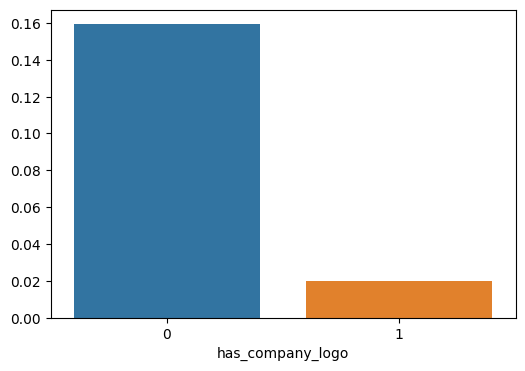

In [84]:
# has_company_logo
has_company_logo_fraud = dataset.groupby('has_company_logo')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=has_company_logo_fraud.index, y=has_company_logo_fraud.values, ax=ax)

<Axes: xlabel='has_company_logo', ylabel='count'>

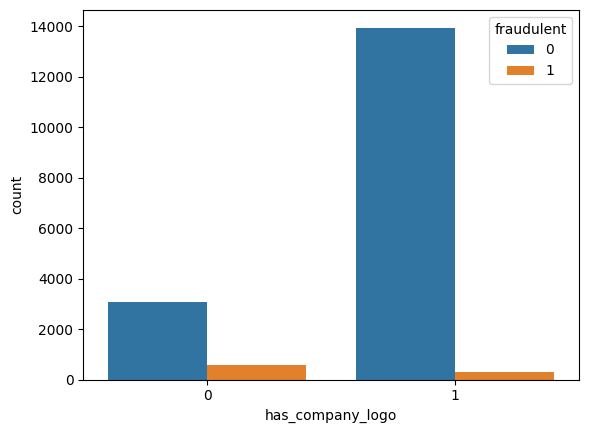

In [85]:
sns.countplot(x='has_company_logo',data=dataset,hue='fraudulent')

<Axes: xlabel='has_questions'>

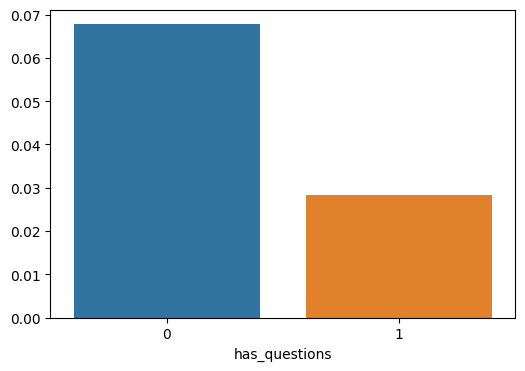

In [86]:
# has_questions
has_questions_fraud = dataset.groupby('has_questions')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=has_questions_fraud.index, y=has_questions_fraud.values, ax=ax)

<Axes: xlabel='has_questions', ylabel='count'>

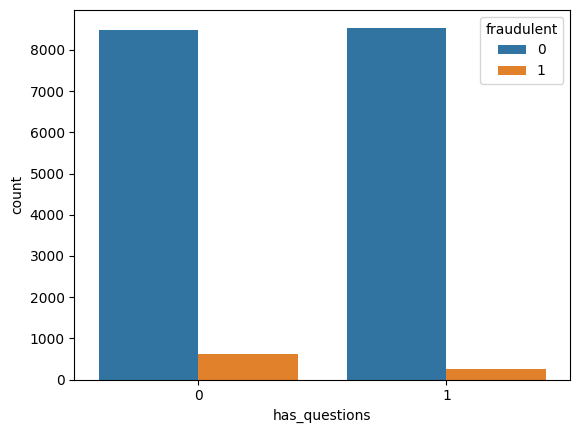

In [87]:
sns.countplot(x='has_questions',data=dataset,hue='fraudulent')

<Axes: xlabel='employment_type'>

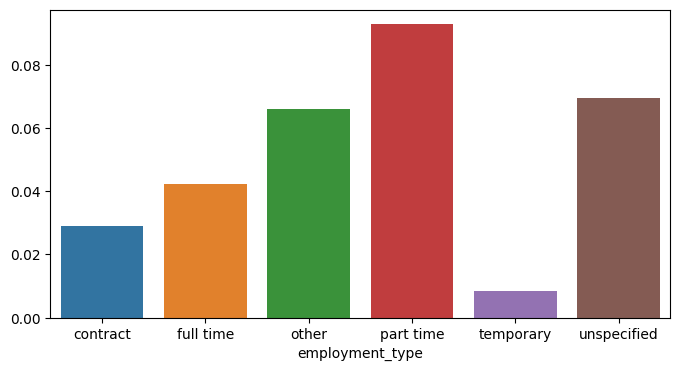

In [88]:
# employment_type
employment_type_fraud = dataset.groupby('employment_type')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.barplot(x=employment_type_fraud.index, y=employment_type_fraud.values, ax=ax)

<Axes: xlabel='employment_type', ylabel='count'>

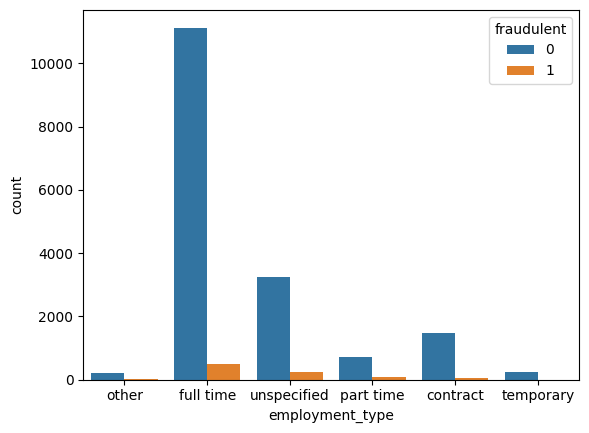

In [89]:
sns.countplot(x='employment_type',data=dataset,hue='fraudulent')

<Axes: xlabel='required_experience'>

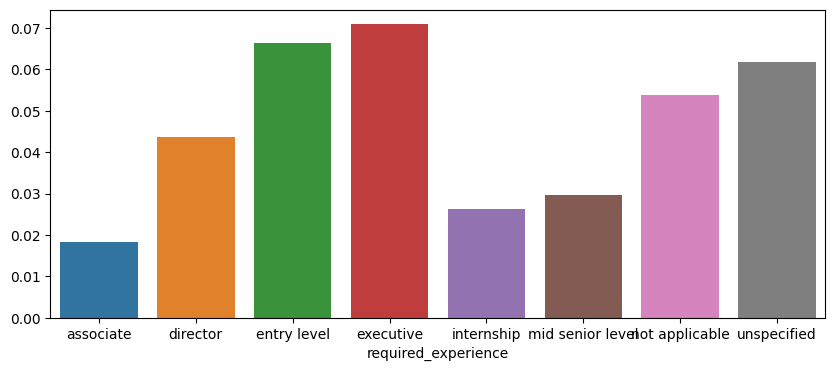

In [90]:
# required_experience
required_experience_fraud = dataset.groupby('required_experience')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.barplot(x=required_experience_fraud.index, y=required_experience_fraud.values, ax=ax)

<Axes: xlabel='required_experience', ylabel='count'>

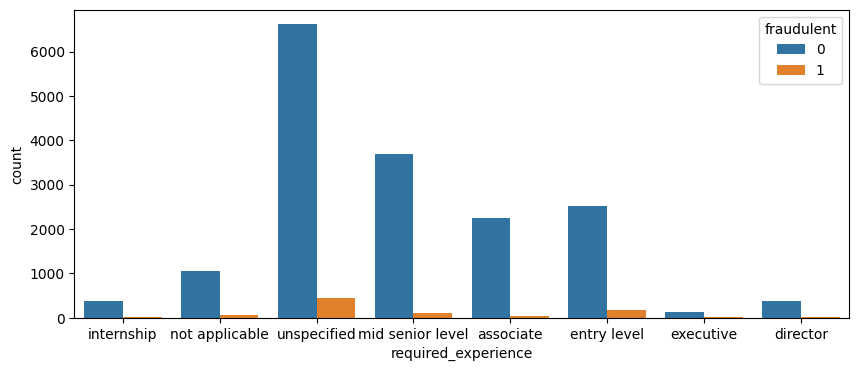

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.countplot(x='required_experience',data=dataset,hue='fraudulent',ax=ax)

In [92]:
# required_education
dataset[dataset['fraudulent']==1]['required_education'].value_counts()

unspecified                          512
high school or equivalent            170
bachelors degree                     100
masters degree                        31
some high school coursework           20
certification                         19
associate degree                       6
professional                           4
some college coursework completed      3
doctorate                              1
Name: required_education, dtype: int64

In [93]:
dataset[dataset['fraudulent']==0]['required_education'].value_counts()

unspecified                          8990
bachelors degree                     5045
high school or equivalent            1910
masters degree                        385
associate degree                      268
certification                         151
some college coursework completed      99
professional                           70
vocational                             49
doctorate                              25
vocational hs diploma                   9
some high school coursework             7
vocational degree                       6
Name: required_education, dtype: int64

In [94]:
# industry
dataset[dataset['fraudulent']==1]['industry'].value_counts().head(5)

unspecified                  275
oil energy                   109
accounting                    57
hospital health care          51
marketing and advertising     45
Name: industry, dtype: int64

In [95]:
dataset[dataset['fraudulent']==0]['industry'].value_counts().head(5)

unspecified                            4628
information technology and services    1702
computer software                      1371
internet                               1062
education management                    822
Name: industry, dtype: int64

In [96]:
# department
dataset[dataset['fraudulent']==1]['department'].value_counts().head(5)

unspecified               531
engineering                60
oil energy                 28
clerical                   27
information technology     27
Name: department, dtype: int64

In [97]:
dataset[dataset['fraudulent']==0]['department'].value_counts().head(5)

unspecified    11016
sales            565
engineering      452
marketing        419
operations       276
Name: department, dtype: int64

In [98]:
# function
dataset[dataset['fraudulent']==1]['function'].value_counts().head(5)

unspecified         337
administrative      119
engineering         113
customer service     67
sales                41
Name: function, dtype: int64

In [99]:
dataset[dataset['fraudulent']==0]['function'].value_counts().head(5)

unspecified               6118
information technology    1717
sales                     1427
engineering               1235
customer service          1162
Name: function, dtype: int64

## 3. Preprocessing

- frequency encoding: title,industry,department,function,salary_range
- embeddings: full_text(company_profile,description,requirements,benefits)
- one-hot encoding: others
- location: split(',') then frequency encoding

In [100]:
df = dataset.copy()

### 3.1 train-test-split

In [101]:
# train test split
from sklearn.model_selection import train_test_split
X = df.drop('fraudulent',axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023,stratify=y)

### 3.2 Encoding

In [102]:
# ordinal encoding for salary_group

from sklearn.preprocessing import OrdinalEncoder

ordinal = OrdinalEncoder(
    categories = [['Extremly Low','Low','Sligtly Low','Slightly High','High','Extremly High' ]],  # order of the categorical values
    handle_unknown = 'use_encoded_value',  #  what to do for unknown values not in the categories list
    unknown_value = -1 # what to replace these unknown values with
)

ordinal.fit_transform(X_train[['salary_group']])

array([[-1.],
       [-1.],
       [-1.],
       ...,
       [-1.],
       [-1.],
       [-1.]])

In [103]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(
    categories = [
            ['Full-time', 'Contract', 'Part-time','Temporary','Other','unavailable'], # employment_type
            ['unavailable', 'Mid-Senior level', 'Entry level', 'Associate', 'Not Applicable', 'Director', 'Internship', 'Executive'], # required_experience
            ['unavailable',"Bachelor's Degree",'High School or equivalent','Unspecified',"Master's Degree",'Associate Degree','Certification','Some College Coursework Completed','Vocational','Professional','Doctorate','Some High School Coursework','Vocational - Degree','Vocational - HS Diploma','Vocational - Other','None','Vocational - HS Certificate','Vocational - Bachelor','Vocational - Master'], # required_education
            ['Information Technology and Services', 'Computer Software','Internet','Marketing and Advertising','Education Management','Financial Services','Hospital & Health Care','Consumer Services','Telecommunications','Oil & Energy','Retail','Real Estate','Accounting','Construction'], # Industry
            ['unavailable','Information Technology','Sales','Engineering','Customer Service','Marketing','Administrative','Design','Health Care Provider','Other','Education','Management','Business Development','Accounting/Auditing','Human Resources','Project Management','Finance','Consulting','Writing/Editing','Art/Creative','Production','Quality Assurance','Data Analyst','Research','Manufacturing','Advertising','Public Relations','Legal','Distribution','Product Management','Strategy/Planning','Purchasing','General Business','Science','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Information Technology','Facilities','QA','Skilled Labor','Business Development','Research Development','Science','Professional Services','Design','Product Management','Strategy/Planning','Purchasing','General Business','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Facilities','QA','Skilled Labor','Research Development','Professional Services','Logistics','Nonprofit','Operations Management','Nurse','Pharmaceutical'], # function
            ['US','GB','GR','CA','DE'] # location_country
     ],
     handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

onehot.fit_transform(X_train[[ 'employment_type', 'required_experience','required_education','industry','function','location_country']])

<12516x119 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [104]:
pd.DataFrame.sparse.from_spmatrix(
    data = onehot.fit_transform(X_train[['employment_type', 'required_experience','required_education','industry','function','location_country']]),  # <- sparse matrix
    columns = onehot.get_feature_names_out(),                        # <- encoded features
    index = X_train.index
)

,employment_type_Full-time,employment_type_Contract,employment_type_Part-time,employment_type_Temporary,employment_type_Other,employment_type_unavailable,required_experience_unavailable,required_experience_Mid-Senior level,required_experience_Entry level,required_experience_Associate,required_experience_Not Applicable,required_experience_Director,required_experience_Internship,required_experience_Executive,required_education_unavailable,required_education_Bachelor's Degree,required_education_High School or equivalent,required_education_Unspecified,required_education_Master's Degree,required_education_Associate Degree,required_education_Certification,required_education_Some College Coursework Completed,required_education_Vocational,required_education_Professional,required_education_Doctorate,required_education_Some High School Coursework,required_education_Vocational - Degree,required_education_Vocational - HS Diploma,required_education_Vocational - Other,required_education_None,required_education_Vocational - HS Certificate,required_education_Vocational - Bachelor,required_education_Vocational - Master,industry_Information Technology and Services,industry_Computer Software,industry_Internet,industry_Marketing and Advertising,industry_Education Management,industry_Financial Services,industry_Hospital & Health Care,industry_Consumer Services,industry_Telecommunications,industry_Oil & Energy,industry_Retail,industry_Real Estate,industry_Accounting,industry_Construction,function_unavailable,function_Information Technology,function_Sales,function_Engineering,function_Customer Service,function_Marketing,function_Administrative,function_Design,function_Health Care Provider,function_Other,function_Education,function_Management,function_Business Development,function_Accounting/Auditing,function_Human Resources,function_Project Management,function_Finance,function_Consulting,function_Writing/Editing,function_Art/Creative,function_Production,function_Quality Assurance,function_Data Analyst,function_Research,function_Manufacturing,function_Advertising,function_Public Relations,function_Legal,function_Distribution,function_Product Management,function_Strategy/Planning,function_Purchasing,function_General Business,function_Science,function_Supply Chain,function_Training,function_Financial Analyst,function_Biotech,function_Inventory,function_Information Technology,function_Facilities,function_QA,function_Skilled Labor,function_Business Development,function_Research Development,function_Science,function_Professional Services,function_Design,function_Product Management,function_Strategy/Planning,function_Purchasing,function_General Business,function_Supply Chain,function_Training,function_Financial Analyst,function_Biotech,function_Inventory,function_Facilities,function_QA,function_Skilled Labor,function_Research Development,function_Professional Services,function_Logistics,function_Nonprofit,function_Operations Management,function_Nurse,function_Pharmaceutical,location_country_US,location_country_GB,location_country_GR,location_country_CA,location_country_DE
11917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [105]:
df.columns

Index(['title', 'department', 'salary_range', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'salary_group', 'location_country', 'location_county',
       'location_city', 'have_company_profile', 'have_requirements',
       'have_benefits', 'full_text', 'text_len'],
      dtype='object')

In [106]:
# Combine them!

numerical_columns = ['telecommuting', 'has_company_logo','has_questions','have_company_profile', 'have_requirements', 'have_benefits','have_department','text_len','company_profile_isna' ]  # numerical columns
ordinal_columns = ['salary_group']        # categorical columns for ordinal encoding
onehot_columns = ['employment_type', 'required_experience','required_education','industry','function','location_country']                   # categorical columns for onehot encoding

from sklearn.compose import ColumnTransformer
encoder = ColumnTransformer([
   #(nickname, transformer to apply, columns to apply to)
    ('numerical', 'passthrough', numerical_columns),   # <- 'passthrough' says to keep them but don't apply anything
    ('ordinal', ordinal, ordinal_columns),             # <- apply ordinal encoder to the ordinal_columns
    ('onehot', onehot, onehot_columns)                 # <- apply onehot encoder to the onehot_columns
])

encoder

ColumnTransformer(transformers=[('numerical', 'passthrough',
                                 ['telecommuting', 'has_company_logo',
                                  'has_questions', 'have_company_profile',
                                  'have_requirements', 'have_benefits',
                                  'have_department', 'text_len',
                                  'company_profile_isna']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['Extremly Low',
                                                             'Low',
                                                             'Sligtly Low',
                                                             'Slightly High',
                                                             'High',
                                                             'Extremly High']],
                                                handle_unknown=...
                                                            'Consulting',
                                                            'Writing/Editing',
                                                            'Art/Creative',
                                                            'Production',
                                                            'Quality Assurance',
                                                            'Data Analyst',
                                                            'Research',
                                                            'Manufacturing',
                                                            'Advertising',
                                                            'Public Relations',
                                                            'Legal',
                                                            'Distribution',
                                                            'Product '
                                                            'Management', ...],
                                                           ['US', 'GB', 'GR',
                                                            'CA', 'DE']],
                                               handle_unknown='ignore'),
                                 ['employment_type', 'required_experience',
                                  'required_education', 'industry', 'function',
                                  'location_country'])])

### 3.3 Get embeddings

In [107]:
## pre trained
## tokenized, embedding layer